# Implementing GPT-2: Building a Large Language Model from Scratch

In the previous notebooks, we learned the individual building blocks:
- **Tokenization** — Converting text to numbers
- **Attention** — How tokens learn to focus on each other
- **Multi-Head Attention** — Multiple attention patterns in parallel

Now it's time to **put everything together** and build a complete GPT-2 model!

---

## What is GPT-2?

GPT-2 (Generative Pre-trained Transformer 2) is a **decoder-only transformer** developed by OpenAI in 2019. It revolutionized NLP by showing that scaling up transformers leads to emergent capabilities.

```
┌─────────────────────────────────────────────────────────────────────────┐
│                         GPT-2 ARCHITECTURE                              │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│    Input: "The cat sat"                                                 │
│              │                                                           │
│              ▼                                                           │
│    ┌─────────────────────┐                                              │
│    │  Token Embeddings   │  "The"→[0.2, 0.5, ...], "cat"→[0.8, 0.1, ...]│
│    │  + Position Embeds  │  pos_0→[...], pos_1→[...], pos_2→[...]       │
│    └──────────┬──────────┘                                              │
│               │                                                          │
│               ▼                                                          │
│    ┌─────────────────────┐                                              │
│    │  Transformer Block  │ ─┐                                           │
│    │  ├─ LayerNorm       │  │                                           │
│    │  ├─ Multi-Head Attn │  │                                           │
│    │  ├─ Residual Add    │  │  × 12 layers                              │
│    │  ├─ LayerNorm       │  │  (for GPT-2 Small)                        │
│    │  ├─ Feed-Forward    │  │                                           │
│    │  └─ Residual Add    │  │                                           │
│    └─────────────────────┘ ─┘                                           │
│               │                                                          │
│               ▼                                                          │
│    ┌─────────────────────┐                                              │
│    │   Final LayerNorm   │                                              │
│    └──────────┬──────────┘                                              │
│               │                                                          │
│               ▼                                                          │
│    ┌─────────────────────┐                                              │
│    │    Output Head      │  Projects back to vocabulary size            │
│    │  (Linear: 768→50257)│                                              │
│    └──────────┬──────────┘                                              │
│               │                                                          │
│               ▼                                                          │
│    Output: [logits for each vocab token]                                │
│            → softmax → next token probabilities                         │
│                                                                          │
└─────────────────────────────────────────────────────────────────────────┘
```

---

## What We'll Build in This Notebook

| Component | Purpose |
|-----------|---------|
| **GPT Config** | Define model hyperparameters |
| **Dummy Model** | Understand the overall structure |
| **Layer Normalization** | Stabilize training |
| **GELU Activation** | Non-linearity for feed-forward |
| **Feed-Forward Network** | Process each token independently |
| **Residual Connections** | Enable training deep networks |

---

## Install Dependencies

In [1]:
!pip install torch tiktoken transformers

---

## Step 1: GPT-2 Configuration

Before building any model, we need to define its **hyperparameters**. These are the architectural choices that determine the model's capacity and behavior.

### GPT-2 Model Variants

| Model | Parameters | Layers | Heads | Embedding Dim |
|-------|-----------|--------|-------|---------------|
| GPT-2 Small | 124M | 12 | 12 | 768 |
| GPT-2 Medium | 355M | 24 | 16 | 1024 |
| GPT-2 Large | 774M | 36 | 20 | 1280 |
| GPT-2 XL | 1.5B | 48 | 25 | 1600 |

We'll implement the **124M (Small)** version.

### Understanding Each Parameter

```
vocab_size: 50257      How many unique tokens the model knows
                       (GPT-2 uses BPE with 50,257 tokens)

context_length: 1024   Maximum sequence length the model can process
                       (how far back it can "remember")

emb_dim: 768          Dimension of token embeddings
                       (each token becomes a 768-dim vector)

n_heads: 12           Number of attention heads
                       (768 ÷ 12 = 64 dims per head)

n_layers: 12          Number of transformer blocks stacked
                       (depth of the network)

drop_rate: 0.1        Dropout probability for regularization
                       (randomly zero out 10% during training)

qkv_bias: False       Whether to use bias in Q, K, V projections
                       (GPT-2 doesn't use bias here)
```

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "emb_dim": 768,          # Embedding dimension
    "n_heads": 12,           # Number of attention heads
    "n_layers": 12,          # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False        # Query-Key-Value bias
}

---

## Step 2: The GPT Model Skeleton (Dummy Version)

Let's first build a **skeleton** of the GPT model to understand its structure. We'll use "dummy" components (that don't do anything) so we can see the overall flow.

### The Model Architecture Breakdown

```
┌─────────────────────────────────────────────────────────────────────────┐
│                         DummyGPTModel                                   │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  1. TOKEN EMBEDDING (tok_emb)                                           │
│     ─────────────────────────                                           │
│     nn.Embedding(50257, 768)                                            │
│     • Maps each token ID → 768-dim vector                               │
│     • Vocab of 50,257 tokens                                            │
│                                                                          │
│  2. POSITION EMBEDDING (pos_emb)                                        │
│     ─────────────────────────────                                       │
│     nn.Embedding(1024, 768)                                             │
│     • Maps each position → 768-dim vector                               │
│     • Positions 0 to 1023 (context length)                              │
│     • Tells model WHERE each token is in the sequence                   │
│                                                                          │
│  3. DROPOUT (drop_emb)                                                  │
│     ──────────────────                                                  │
│     nn.Dropout(0.1)                                                     │
│     • Regularization: randomly zeros 10% of values                      │
│                                                                          │
│  4. TRANSFORMER BLOCKS (trf_blocks)                                     │
│     ───────────────────────────────                                     │
│     12 × TransformerBlock                                               │
│     • The "meat" of the model                                           │
│     • Each block: Attention + FeedForward + Residuals                   │
│                                                                          │
│  5. FINAL LAYER NORM (final_norm)                                       │
│     ─────────────────────────────                                       │
│     LayerNorm(768)                                                      │
│     • Normalize before final projection                                 │
│                                                                          │
│  6. OUTPUT HEAD (out_head)                                              │
│     ──────────────────────                                              │
│     nn.Linear(768, 50257, bias=False)                                   │
│     • Projects back to vocabulary size                                  │
│     • Output: logits for each possible next token                       │
│                                                                          │
└─────────────────────────────────────────────────────────────────────────┘
```

### The Forward Pass

```python
def forward(self, in_idx):
    # in_idx shape: [batch_size, seq_len]  e.g., [2, 4]
    
    # 1. Get token embeddings
    tok_embeds = self.tok_emb(in_idx)      # [2, 4, 768]
    
    # 2. Get position embeddings (0, 1, 2, 3)
    pos_embeds = self.pos_emb(torch.arange(seq_len))  # [4, 768]
    
    # 3. Add them together (broadcasting!)
    x = tok_embeds + pos_embeds            # [2, 4, 768]
    
    # 4. Apply dropout
    x = self.drop_emb(x)                   # [2, 4, 768]
    
    # 5. Pass through all transformer blocks
    x = self.trf_blocks(x)                 # [2, 4, 768]
    
    # 6. Final normalization
    x = self.final_norm(x)                 # [2, 4, 768]
    
    # 7. Project to vocabulary logits
    logits = self.out_head(x)              # [2, 4, 50257]
    
    return logits
```

**Note:** The dummy transformer blocks and layer norm just pass through the input unchanged. We'll implement the real versions later!

In [3]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg)
              for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

---

## Step 3: Preparing Input Data

Before we can use our model, we need to convert text into token IDs. Let's use the same tokenizer that GPT-2 uses: **tiktoken** with the "gpt2" encoding.

### What Happens During Tokenization

```
Text: "Every effort moves you"
                │
                ▼
         Tokenizer (BPE)
                │
                ▼
Token IDs: [6109, 3626, 6100, 345]
            "Every" "effort" "moves" "you"
```

We'll create a **batch** of two sentences to demonstrate batch processing:

In [4]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


### Understanding the Batch

```
batch shape: [2, 4]
              ↑  ↑
         batch  sequence
         size   length

Sentence 1: [6109, 3626, 6100,  345]  → "Every effort moves you"
Sentence 2: [6109, 1110, 6622,  257]  → "Every day holds a"
```

Now let's pass this batch through our dummy model and see what comes out:

In [5]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


### Understanding the Model Output

```
Output shape: [2, 4, 50257]
               ↑  ↑    ↑
            batch seq vocab_size

For each token position, we get 50,257 logits (one for each possible next token)
```

**What are logits?**
- Raw (unnormalized) scores for each vocabulary token
- Higher logit = model thinks that token is more likely to come next
- Apply softmax to convert to probabilities

**Example:** For position 0 of sentence 1 ("Every"), the model outputs 50,257 numbers. The token with the highest logit would be the model's "guess" for what comes after "Every".

Since our model is untrained (random weights) and uses dummy components, these outputs are meaningless. But the **shape is correct**!

---

## Step 4: Layer Normalization — Stabilizing Training

Now let's implement a real component: **Layer Normalization**.

### Why Do We Need Normalization?

Deep neural networks suffer from **internal covariate shift** — the distribution of inputs to each layer changes during training, making optimization difficult.

**The Problem:**
```
Layer 1 output: [0.001, 0.002, 0.003, ...]      Very small values
Layer 2 output: [1000, 2000, 3000, ...]         Very large values
Layer 3 output: [0.00001, 0.00002, ...]         Tiny values again!

This instability makes training very slow and difficult.
```

**The Solution: Normalize each layer's output to have:**
- Mean ≈ 0
- Variance ≈ 1

### Layer Norm vs Batch Norm

```
BATCH NORMALIZATION                    LAYER NORMALIZATION
(normalize across batch)               (normalize across features)

  Feature 1  Feature 2  Feature 3        Feature 1  Feature 2  Feature 3
  ─────────  ─────────  ─────────        ─────────  ─────────  ─────────
┌──────────────────────────────┐     ┌──────────────────────────────┐
│ Sample 1 │   0.5   │   0.8   │     │ Sample 1 │   0.5   │   0.8   │ ← normalize
│          │         │         │     ├──────────────────────────────┤   this row
│ Sample 2 │   0.3   │   0.6   │     │ Sample 2 │   0.3   │   0.6   │ ← normalize
│          │         │         │     ├──────────────────────────────┤   this row
│ Sample 3 │   0.7   │   0.4   │     │ Sample 3 │   0.7   │   0.4   │ ← normalize
└──────────────────────────────┘     └──────────────────────────────┘   this row
      ↑           ↑         ↑
   normalize   normalize  normalize
   this col    this col   this col

Batch Norm: depends on batch size     Layer Norm: independent of batch
            problematic for LLMs                  perfect for LLMs!
```

**GPT-2 uses Layer Normalization** because it works the same way regardless of batch size.

Let's see how normalization works step by step:

In [6]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


### Step 4.1: Create Sample Data

We created a small batch (2 samples, 5 features each) and passed it through a simple layer. Notice:
- Some values are 0 (ReLU zeros out negatives)
- Values vary quite a bit

Now let's compute the **mean** and **variance** for each sample (across features):

In [7]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


### Step 4.2: The Normalization Formula

Now we apply the normalization formula:

```
                    x - mean
normalized_x = ─────────────────
                  √(variance)
```

This shifts the data to have mean=0 and scales it to have variance=1:

In [8]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### Understanding the Result

After normalization:
- **Mean ≈ 0** (actually ~9.9e-09, essentially zero)
- **Variance = 1** (exactly!)

The mean shows in scientific notation. Let's display it more clearly:

In [9]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### Step 4.3: The LayerNorm Class

Now let's wrap this into a proper PyTorch module. Layer Normalization adds two **learnable parameters**:

```
output = scale * normalized_x + shift
         ─────                  ─────
         γ (gamma)              β (beta)
```

**Why learnable scale and shift?**

Pure normalization (mean=0, var=1) might be too restrictive. The model might need the output to have a different distribution. So we let it learn:
- `scale` (γ): multiplies the normalized values
- `shift` (β): adds an offset

Initially: scale=1, shift=0 (so output = normalized_x)

During training, the model can adjust these to whatever works best!

In [10]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

### Testing Our LayerNorm

Let's verify it works — the output should have mean≈0 and variance≈1 for each sample:

In [11]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


**LayerNorm is working!** Both samples now have mean≈0 and variance=1.

---

## Step 5: GELU Activation Function

Neural networks need **non-linear activation functions** to learn complex patterns. Without them, stacking layers would just be equivalent to a single linear transformation.

### Why Not Just Use ReLU?

**ReLU (Rectified Linear Unit):**
```
ReLU(x) = max(0, x)

    │
    │      ╱
    │     ╱
    │    ╱
────┼───────────
    │
```
- Simple: negative → 0, positive → unchanged
- **Problem:** "Dead neurons" — once a neuron outputs 0, it might never recover

**GELU (Gaussian Error Linear Unit):**
```
GELU(x) = x · Φ(x)    where Φ is the cumulative distribution function of N(0,1)

    │         ╱
    │       ╱╱
    │     ╱╱
    │  ╱╱╱
────┼─────────────
   ╱│
```
- Smooth approximation of ReLU
- Allows small negative values (not hard cutoff at 0)
- **GPT-2 and BERT use GELU** for better performance

### The GELU Formula

The exact GELU uses the error function, but GPT-2 uses an approximation:

```python
GELU(x) ≈ 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x³)))
```

This approximation is faster to compute and works well in practice.

In [12]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

### Visualizing GELU vs ReLU

Let's plot both activation functions to see the difference:

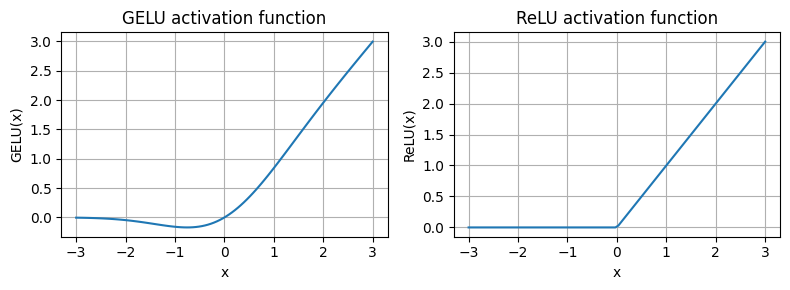

In [13]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

**Key Differences:**

| Feature | ReLU | GELU |
|---------|------|------|
| Negative values | Hard 0 | Smooth, small negative allowed |
| At x=0 | Sharp corner | Smooth transition |
| Gradient at 0 | Undefined/0 | Smooth gradient |
| Dead neurons | Can happen | Less likely |

---

## Step 6: Feed-Forward Network

Each transformer block has a **Feed-Forward Network (FFN)** that processes each token independently. It's like giving each token a chance to "think" on its own after attending to other tokens.

### FFN Structure

```
┌─────────────────────────────────────────────────────────────────────────┐
│                        FEED-FORWARD NETWORK                             │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  Input: [batch, seq, 768]                                               │
│              │                                                           │
│              ▼                                                           │
│    ┌─────────────────────┐                                              │
│    │  Linear(768 → 3072) │  ← Expand to 4× dimension                    │
│    │     768 × 4 = 3072  │                                              │
│    └──────────┬──────────┘                                              │
│               │                                                          │
│               ▼                                                          │
│    ┌─────────────────────┐                                              │
│    │       GELU()        │  ← Non-linearity                             │
│    └──────────┬──────────┘                                              │
│               │                                                          │
│               ▼                                                          │
│    ┌─────────────────────┐                                              │
│    │  Linear(3072 → 768) │  ← Project back down                         │
│    └──────────┬──────────┘                                              │
│               │                                                          │
│               ▼                                                          │
│  Output: [batch, seq, 768]                                              │
│                                                                          │
└─────────────────────────────────────────────────────────────────────────┘
```

### Why Expand then Contract?

The "expand to 4×" pattern is crucial:
1. **Expand:** Projects to higher dimension (768 → 3072)
2. **Non-linearity:** GELU activation
3. **Contract:** Projects back down (3072 → 768)

This gives the network more capacity to learn complex transformations while keeping the output dimension consistent.

In [14]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

### Testing the FeedForward Network

Let's verify the input and output shapes are the same:

In [15]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


**Input shape: [2, 3, 768] → Output shape: [2, 3, 768]**

The shapes match, as expected. The FeedForward network processes each token's 768-dim embedding independently.

---

## Step 7: Residual Connections (Skip Connections)

Now we come to one of the most important innovations in deep learning: **residual connections** (also called skip connections).

### The Problem: Vanishing Gradients

When training deep networks, gradients must flow backward through many layers. With each layer, gradients tend to get smaller and smaller:

```
Layer 5 gradient: 0.1
Layer 4 gradient: 0.01       (0.1 × 0.1)
Layer 3 gradient: 0.001      (0.01 × 0.1)
Layer 2 gradient: 0.0001     (0.001 × 0.1)
Layer 1 gradient: 0.00001    (0.0001 × 0.1)  ← Almost zero! Can't learn!
```

**Deep layers can't learn because gradients vanish!**

### The Solution: Add Instead of Replace

Instead of:
```python
x = layer(x)  # Replace x with layer output
```

We do:
```python
x = x + layer(x)  # Add layer output to original x
```

```
┌─────────────────────────────────────────────────────────────────────────┐
│                      RESIDUAL CONNECTION                                │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│     Without Residual:                  With Residual:                   │
│     ─────────────────                  ──────────────                   │
│                                                                          │
│         x                                  x ─────────────┐              │
│         │                                  │              │              │
│         ▼                                  ▼              │              │
│     ┌───────┐                          ┌───────┐         │              │
│     │ Layer │                          │ Layer │         │ (skip)       │
│     └───┬───┘                          └───┬───┘         │              │
│         │                                  │              │              │
│         ▼                                  ▼              │              │
│      output                            ┌───┴───┐         │              │
│                                        │   +   │◄────────┘              │
│                                        └───┬───┘                        │
│                                            │                            │
│                                            ▼                            │
│                                         output                          │
│                                      = x + layer(x)                     │
│                                                                          │
└─────────────────────────────────────────────────────────────────────────┘
```

### Why This Works

The gradient can now flow through TWO paths:
1. Through the layer (might vanish)
2. Through the skip connection (preserved!)

```
Gradient flow WITH residual:

Layer 5: grad = 0.1 + 0.5 (skip) = 0.6
Layer 4: grad = 0.06 + 0.5 (skip) = 0.56
Layer 3: grad = 0.056 + 0.5 (skip) = 0.556
Layer 2: grad = 0.0556 + 0.5 (skip) = 0.5556
Layer 1: grad = 0.05556 + 0.5 (skip) = 0.55556  ← Still significant!
```

**The skip connection acts like a "gradient highway"!**

### Demonstrating the Effect

Let's build a simple deep network and compare gradients with and without residual connections:

In [16]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), 
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), 
                          GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

### Understanding the Example Network

The `ExampleDeepNeuralNetwork` has:
- 5 layers (making it "deep")
- A `use_shortcut` flag to enable/disable residual connections
- The key line: `if self.use_shortcut and x.shape == layer_output.shape: x = x + layer_output`

Let's create a network WITHOUT shortcuts first:

In [17]:
layer_sizes = [3, 3, 3, 3, 3, 1]  
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

### Measuring Gradient Flow

To see how gradients flow through the network, we'll:
1. Do a forward pass
2. Compute a loss
3. Backpropagate (compute gradients)
4. Print the gradient magnitude for each layer's weights

In [18]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

### Gradients WITHOUT Residual Connections

Let's see what happens with a regular deep network (no shortcuts):

In [19]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


### Analyzing the Results (Without Shortcuts)

Look at the gradient magnitudes:
```
Layer 0: 0.00020   ← Very small! (first layer)
Layer 1: 0.00012   ← Even smaller!
Layer 2: 0.00072
Layer 3: 0.00140
Layer 4: 0.00505   ← Largest (closest to output)
```

**The gradients are TINY for early layers!** This is the vanishing gradient problem.

### Gradients WITH Residual Connections

Now let's enable shortcuts and see the difference:

In [20]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


### The Dramatic Difference!

| Layer | Without Shortcuts | With Shortcuts | Improvement |
|-------|------------------|----------------|-------------|
| 0 | 0.00020 | 0.22170 | **1100×** |
| 1 | 0.00012 | 0.20694 | **1700×** |
| 2 | 0.00072 | 0.32897 | **460×** |
| 3 | 0.00140 | 0.26657 | **190×** |
| 4 | 0.00505 | 1.32585 | **260×** |

**With residual connections, gradients are 100-1700× larger!**

The early layers can now learn effectively because gradients flow through the skip connections.

---

## Summary: Building Blocks of GPT-2

We've now implemented all the key components needed for a GPT-2 model:

```
┌─────────────────────────────────────────────────────────────────────────┐
│                    GPT-2 BUILDING BLOCKS                                │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  ✓ Configuration       Define model hyperparameters                     │
│                                                                          │
│  ✓ Embeddings          Token + Position embeddings                      │
│                        (nn.Embedding)                                   │
│                                                                          │
│  ✓ Layer Normalization Stabilize training                               │
│                        (mean=0, var=1, learnable scale/shift)           │
│                                                                          │
│  ✓ GELU Activation     Smooth non-linearity                             │
│                        (better than ReLU for transformers)              │
│                                                                          │
│  ✓ Feed-Forward Net    Expand → GELU → Contract                         │
│                        (768 → 3072 → 768)                               │
│                                                                          │
│  ✓ Residual Connections Enable deep networks                            │
│                        (x + layer(x))                                   │
│                                                                          │
│  ○ Multi-Head Attention (from previous notebook)                        │
│                                                                          │
│  ○ Transformer Block   Combine all components                           │
│                        (next notebook!)                                 │
│                                                                          │
└─────────────────────────────────────────────────────────────────────────┘
```

### Key Takeaways

| Component | Purpose | Key Insight |
|-----------|---------|-------------|
| **LayerNorm** | Stabilize activations | Normalize per-sample, not per-batch |
| **GELU** | Non-linearity | Smooth alternative to ReLU |
| **FeedForward** | Per-token processing | 4× expansion gives more capacity |
| **Residual** | Enable depth | Gradient highway prevents vanishing |

### What's Next?

In the next notebook, we'll combine these components with Multi-Head Attention to build a complete **Transformer Block**, and then stack 12 of them to create the full GPT-2 model!